In [1]:
import json
import pandas
import numpy as np
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

In [2]:
answer_df = pandas.read_csv('./trialdata.csv', header=None)

In [3]:
known_ids = {
    'student1': 'debugRX1T44',
    'student2': 'debugMMCIA3',
    'student3': 'debugICSTO3',
    'student4': 'debugNVKH3L',
#     'student14': 'debugND4Z8L', # omitted due to experimental error
    'student5': 'debugR2Y9V1',
    'student6': 'debug4IMY4D',
    'student7': 'debug6RKBCG',
    'dev1': 'debugR5803T',
    'dev2': 'debugF7DGJB',
    'dev3': 'debugVH4LTP',
    'dev4': 'debugOI6CE3',
    'dev5': 'debugAYW103',
    'dev6': 'debugCH6YG0',
    'student8': 'debugOB2BNG',
    'student9': 'debug017S2H',
    'student10': 'debugS2AV55',
    'student11': 'debugUQ66MB',
    'student12': 'debug2M4ZY7',
    'student13': 'debugM6TAQ4',
}
answer_df['answerer'] = 'unknown'
for name, user_id in known_ids.items():
    answer_df.loc[answer_df[0].str.contains(user_id), 'answerer'] = name

In [4]:
CUTOFF_INDEX = 12
refined_df = answer_df[(answer_df['answerer'] != 'unknown') & (answer_df[1] <= CUTOFF_INDEX)]
refined_df.head()

,0,1,2,3,answerer
643,debugE024QU:debugRX1T44,0,1679443814520,"{""phase"": ""INSTRUCTIONS"", ""templates"": [""instr...",student1
644,debugE024QU:debugRX1T44,1,1679443818873,"{""phase"": ""INSTRUCTIONS"", ""template"": ""instruc...",student1
645,debugE024QU:debugRX1T44,2,1679443822239,"{""phase"": ""INSTRUCTIONS"", ""template"": ""instruc...",student1
646,debugE024QU:debugRX1T44,3,1679443939612,"{""phase"": ""INSTRUCTIONS"", ""template"": ""instruc...",student1
647,debugE024QU:debugRX1T44,4,1679443951499,"{""phase"": ""INSTRUCTIONS"", ""template"": ""instruc...",student1


In [5]:
refined_df[3].iloc[-6]

'{"phase": "TEST", "bug_name": "ARHE166", "info_level": 1, "used_explanation": true, "q1_answ": "yes", "q2_answ": "It is semantically correct.\\n*I think the code writer intended line 22 to do the condition checking about \'len(lst[0]) == 0\'.\\nIt would have been better if the program fixed line 22 by changing the whole condition to \'if len(lst[0]) == 0\'. But on second thought, the program can\'t be sure that line 22 is intended or not... So changing this way would be much safe (in conservative view)", "q3_answ": "yes", "rt": 375119}'

In [6]:
q_answs = {
    'ARHE080': False,
    'ARHE105': False,
    'ARHE114': True,
    'ARHE133': True,
    'ARHE110': True,
    'ARHE166': True,
    'BIP001': True,
    'BIP002': False,
    'BIP003': True,
    'BIP004': False,
    'BIP005': True,
    'BIP006': True,
}
is_correct = []
is_incorrect = [] # completely wrong, not even unsure
time_spent = []
hint_provided = []
hint_helped = []
reasoning = []
q_name = []
is_prob = []
for _, row in refined_df.iterrows():
    resp_obj = json.loads(row[3])
    if resp_obj['phase'] == 'TEST':
        true_answ = q_answs[resp_obj['bug_name']]
        resp_answ = resp_obj['q1_answ']
        resp_correct = (resp_answ.lower() == ('yes' if true_answ else 'no'))
        is_correct.append(resp_correct)
        is_incorrect.append((not resp_correct) and (resp_answ.lower() != 'unsure'))
        reasoning.append(resp_obj['q2_answ'])
    else:
        is_correct.append(False)
        is_incorrect.append(False)
        reasoning.append('')
    is_prob.append('rt' in resp_obj)
    if 'rt' in resp_obj:
        time_spent.append(resp_obj['rt'])
        hint_provided.append(resp_obj['info_level']==1)
        q_name.append(resp_obj['bug_name'])
        hint_helped.append(resp_obj['q3_answ'])
    else:
        time_spent.append(-1)
        hint_provided.append(False)
        q_name.append('<none>')
        hint_helped.append('<none>')
refined_df['correct'] = is_correct
refined_df['incorrect'] = is_incorrect
refined_df['time'] = time_spent
refined_df['hint_given'] = hint_provided
refined_df['is_problem'] = is_prob
refined_df['q_name'] = q_name
refined_df['hint_helped'] = hint_helped
refined_df['reasoning'] = reasoning
# refined_df.head(20)

/home/sungmin/Documents/projects_21/ninedlenv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


/home/sungmin/Documents/projects_21/ninedlenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


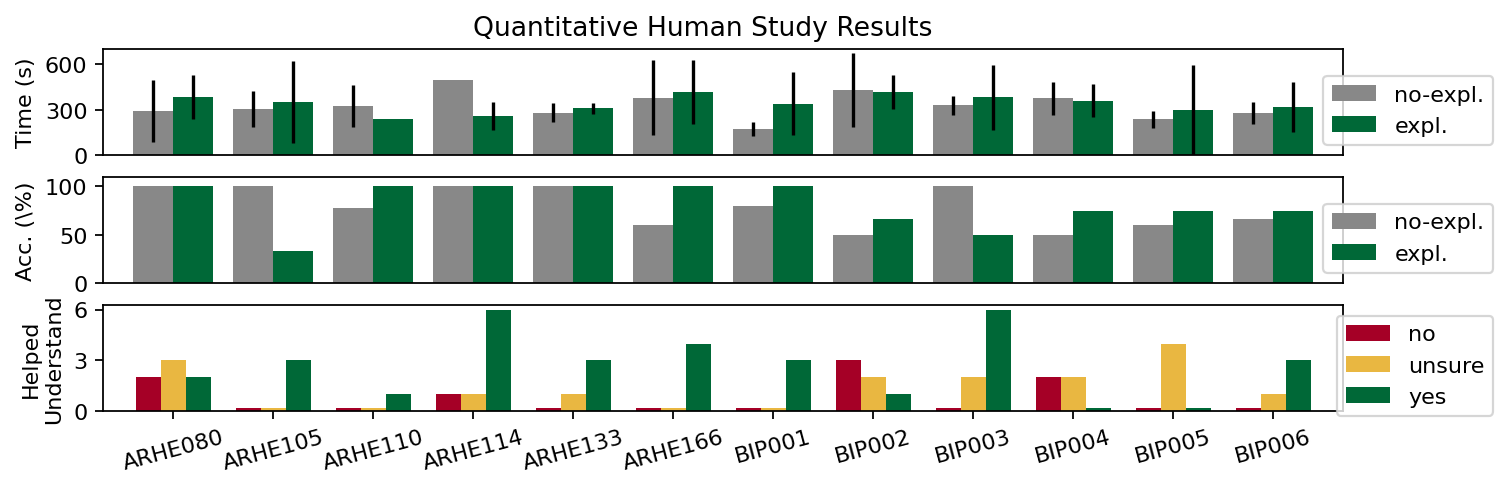

In [7]:
fig, axs = plt.subplots(3, figsize=(10, 3), dpi=160)

def draw_time_dist(ax, data_df, bug_name, x_idx, add_labels=False):
    # drawing parameters
    start_loc = -0.2
    x_diff = 0.4
    width = x_diff
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    color_map = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')
    
    time_w_hint_by_q = data_df[data_df.is_problem & data_df.hint_given].groupby('q_name')['time'].mean()/1000
    std_w_hint_by_q = data_df[data_df.is_problem & data_df.hint_given].groupby('q_name')['time'].std()/1000
    count_w_hint_by_q = data_df[data_df.is_problem & data_df.hint_given].groupby('q_name')['time'].count()
    time_wo_hint_by_q = data_df[data_df.is_problem & ~data_df.hint_given].groupby('q_name')['time'].mean()/1000
    std_wo_hint_by_q = data_df[data_df.is_problem & ~data_df.hint_given].groupby('q_name')['time'].std()/1000
    count_wo_hint_by_q = data_df[data_df.is_problem & ~data_df.hint_given].groupby('q_name')['time'].count()
    
    x_locs = [x_idx+start_loc, x_idx+start_loc+x_diff]
    keys = ['no-expl.', 'expl.']
    key_colors = ['#888', color_map.to_rgba(1)]
    if 'all' not in bug_name:
#         values = [data_df[data_df.is_problem & ~data_df.hint_given & (data_df.q_name == bug_name)]['time'],
#                   data_df[data_df.is_problem & data_df.hint_given & (data_df.q_name == bug_name)]['time'],]
        values = [s[s.index == bug_name].item() for s in [time_wo_hint_by_q, time_w_hint_by_q]]
        error_sizes = [1.96*s[s.index == bug_name].item() / np.sqrt(n[n.index == bug_name].item())
                       for s, n in zip([std_wo_hint_by_q, std_w_hint_by_q],
                                    [count_wo_hint_by_q, count_w_hint_by_q])]
    else:
        dataset_name = bug_name.split('-')[0]
        arhe_w_q_idx = data_df.is_problem & data_df.hint_given & (data_df.q_name.str.contains(dataset_name))
        arhe_wo_q_idx = data_df.is_problem & (~data_df.hint_given) & (data_df.q_name.str.contains(dataset_name))
        time_w_hint = data_df[arhe_w_q_idx]['time'].mean().mean()/1000
        time_wo_hint = data_df[arhe_wo_q_idx]['time'].mean().mean()/1000
        values = [time_wo_hint, time_w_hint]
        std_w_hint = 1.96*data_df[arhe_w_q_idx]['time'].std()/np.sqrt(arhe_w_q_idx.sum())/1000
        std_wo_hint = 1.96*data_df[arhe_wo_q_idx]['time'].std()/np.sqrt(arhe_wo_q_idx.sum())/1000
        error_sizes = [std_wo_hint, std_w_hint]
    for i, (x_loc, key) in enumerate(zip(x_locs, keys)):
#         ax.boxplot([e/1000 for e in values[i]], positions=[x_loc], widths=[width],)
#                    label=key if add_labels else '',)
        ax.bar(x_loc, values[i], color=key_colors[i], width=width, label=key if add_labels else '',
               hatch='///' if 'all' in bug_name else '')
        ax.errorbar(x_loc, values[i], yerr=min(error_sizes[i], values[i]), color='black')
    

def draw_acc_dist(ax, data_df, bug_name, x_idx, add_labels=False):
    # drawing parameters
    start_loc = -0.2
    x_diff = 0.4
    width = x_diff
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    color_map = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')
    
    acc_w_hint_by_q = data_df[data_df.is_problem & data_df.hint_given].groupby('q_name')['correct'].mean()
    acc_wo_hint_by_q = data_df[data_df.is_problem & ~data_df.hint_given].groupby('q_name')['correct'].mean()
    
    x_locs = [x_idx+start_loc, x_idx+start_loc+x_diff]
    keys = ['no-expl.', 'expl.']
    key_colors = ['#888', color_map.to_rgba(1)]
    if 'all' not in bug_name:
        values = [s[s.index == bug_name].item() for s in [acc_wo_hint_by_q, acc_w_hint_by_q]]
    else:
        dataset_name = bug_name.split('-')[0]
        data_w_q_idx = data_df.is_problem & data_df.hint_given & (data_df.q_name.str.contains(dataset_name))
        data_wo_q_idx = data_df.is_problem & (~data_df.hint_given) & (data_df.q_name.str.contains(dataset_name))
        acc_w_hint = data_df[data_w_q_idx].groupby('q_name')['correct'].mean().mean()
        acc_wo_hint = data_df[data_wo_q_idx].groupby('q_name')['correct'].mean().mean()
        values = [acc_wo_hint, acc_w_hint]
    for i, (x_loc, key) in enumerate(zip(x_locs, keys)):
        ax.bar(x_loc, values[i]*100, color=key_colors[i], width=width, label=key if add_labels else '',
               hatch='///' if 'all' in bug_name else '')
    
def draw_understand_dist(ax, count_series, bug_name, x_idx, add_labels=False):
    # drawing parameters
    start_loc = -0.25
    x_diff = 0.25
    width = x_diff
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    color_map = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')
    
    keys = ['no', 'unsure', 'yes']
    key_color = [color_map.to_rgba(0), '#e9b741', color_map.to_rgba(1)]
    x_diffs = [x_idx + start_loc + i*x_diff for i in range(len(keys))]
    val_count = {}
    for key in keys:
        try:
            if 'all' not in bug_name:
                val_count[key] = count_series[count_series.index == (bug_name, key)].item()
            else:
                dname = bug_name.split('-')[0]
                brr = refined_df[refined_df.is_problem & (refined_df.q_name.str.contains(dname)) & (refined_df.hint_given)]['hint_helped'].value_counts()
                val_count[key] = brr[key]/6
                
        except ValueError:
            val_count[key] = 0.2
    for i, (x_loc, key) in enumerate(zip(x_diffs, keys)):
        ax.bar(x_loc, val_count[key], color=key_color[i], width=width, label=key if add_labels else '',
               hatch='///' if 'all' in bug_name else '')

bug_order = [
    'ARHE080',
    'ARHE105',
    'ARHE110',
    'ARHE114',
    'ARHE133',
    'ARHE166',
#     'ARHE-all',
    'BIP001',
    'BIP002',
    'BIP003',
    'BIP004',
    'BIP005',
    'BIP006',
#     'BIP-all',
]
helped_w_hint_by_q = refined_df[refined_df.is_problem].groupby('q_name')['hint_helped'].value_counts()
for idx, bug_name in enumerate(bug_order):
    draw_time_dist(axs[0], refined_df, bug_name, idx, add_labels=(idx==0))
    draw_acc_dist(axs[1], refined_df, bug_name, idx, add_labels=(idx==0))
    draw_understand_dist(axs[2], helped_w_hint_by_q, bug_name, idx, add_labels=(idx==0))

axs[0].set_xticks([])
axs[0].legend(bbox_to_anchor = (1.13, 0.85))
axs[0].set_ylabel('Time (s)')
axs[0].set_ylim([0, 700])
axs[0].set_xlim([-0.7, len(bug_order)-1+0.7])
axs[0].set_yticks([0, 300, 600])
axs[1].set_xticks([])
axs[1].set_ylim([0, 110])
axs[1].legend(bbox_to_anchor = (1.13, 0.85))
axs[1].set_ylabel('Acc. (\\%)')
axs[1].set_yticks([0, 50, 100])
axs[1].set_xlim([-0.7, len(bug_order)-1+0.7])
axs[2].set_xticks(range(len(bug_order)))
axs[2].set_yticks(range(0, 7, 3))
axs[2].set_xticklabels(bug_order, rotation=15)
axs[2].set_ylabel('Helped\nUnderstand')
axs[2].legend(bbox_to_anchor = (1.13, 1.00))
axs[2].xaxis.grid(False)
axs[2].set_xlim([-0.7, len(bug_order)-1+0.7])
plt.suptitle('Quantitative Human Study Results', x=0.5, y=0.95)
plt.savefig('rq4_quantitative.pdf', bbox_inches='tight')

In [8]:
pqnre_df = pandas.read_csv('./questiondata.csv', header=None)
pqnre_df['answerer'] = 'unknown'
known_ids['student14'] = 'debugND4Z8L'
for name, user_id in known_ids.items():
    pqnre_df.loc[pqnre_df[0].str.contains(user_id), 'answerer'] = name
pqnre_df.tail(10)

,0,1,2,answerer
223,debugVSK49T:debugM6TAQ4,status,1.0,student13
224,debugVSK49T:debugM6TAQ4,prog_exp,1.0,student13
225,debugVSK49T:debugM6TAQ4,python_exp,1.0,student13
226,debugVSK49T:debugM6TAQ4,apr_knowledge,3.0,student13
227,debugVSK49T:debugM6TAQ4,apr_desirability,3.0,student13
228,debugVSK49T:debugM6TAQ4,expl_help_decision,5.0,student13
229,debugVSK49T:debugM6TAQ4,expl_help_confidence,4.0,student13
230,debugVSK49T:debugM6TAQ4,header_utility,2.0,student13
231,debugVSK49T:debugM6TAQ4,detail_utility,4.0,student13
232,debugVSK49T:debugM6TAQ4,actual_exec,3.0,student13


In [9]:
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

In [10]:
perf_qs = [
    'apr_desirability',
    'expl_help_decision',
    'expl_help_confidence',
    'header_utility',
    'detail_utility',
    'actual_exec'
]
known_pqnre_answs = pqnre_df[(pqnre_df.answerer != 'unknown') & (pqnre_df.answerer.str.contains('dev'))]
for key in perf_qs:
    print(key, Counter(known_pqnre_answs[known_pqnre_answs[1]==key][2]))

apr_desirability Counter({3.0: 2, 4.0: 2, 5.0: 1, 2.0: 1})
expl_help_decision Counter({3.0: 3, 5.0: 2, 4.0: 1})
expl_help_confidence Counter({3.0: 4, 2.0: 1, 5.0: 1})
header_utility Counter({3.0: 2, 4.0: 2, 2.0: 1, 1.0: 1})
detail_utility Counter({3.0: 2, 4.0: 2, 2.0: 2})
actual_exec Counter({3.0: 3, 4.0: 3})


In [11]:
# dev_pqnre_answs = pqnre_df[(pqnre_df.answerer != 'unknown') & (pqnre_df.answerer.str.contains('dev'))]

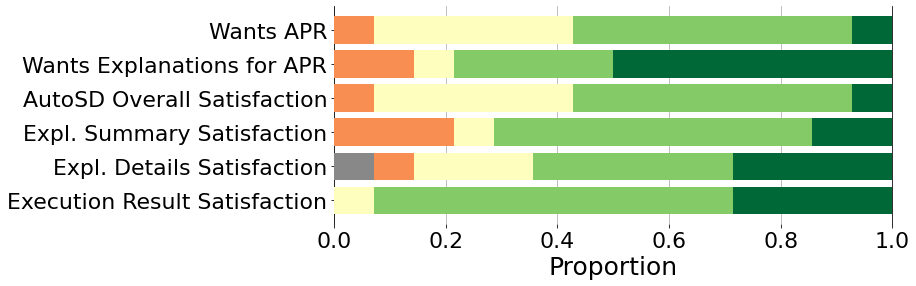

In [12]:
known_pqnre_answs = pqnre_df[(pqnre_df.answerer != 'unknown') & (pqnre_df.answerer.str.contains('student'))]

zero2five_likerts = []
for key in perf_qs:
    zero2five_likerts.append({
        'key': key,
        'resps': Counter(known_pqnre_answs[known_pqnre_answs[1]==key][2]),
    })

level_values = [[] for _ in range(6)]
for likert_obj in zero2five_likerts:
    key, counter_obj = likert_obj['key'], likert_obj['resps']
    total_resps = sum(counter_obj.values())
    for i in range(6):
        if i in counter_obj:
            level_values[i].append(counter_obj[i]/total_resps)
        else:
            level_values[i].append(0)

cNorm  = colors.Normalize(vmin=0, vmax=1)
color_map = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')

pretty_names = OrderedDict({
    'apr_desirability': 'Wants APR',
    'expl_help_decision': 'Wants Explanations for APR',
    'expl_help_confidence': 'AutoSD Overall Satisfaction',
    'header_utility': 'Expl. Summary Satisfaction',
    'detail_utility': 'Expl. Details Satisfaction',
    'actual_exec': 'Execution Result Satisfaction'
})
level_labels = OrderedDict({
    0: '0 (unused)',
    1: '1 (no)',
    2: '2',
    3: '3',
    4: '4',
    5: '5 (yes)'
})
    
plt.rcParams['figure.figsize'] = [10, 4]
yrange = range(5, -1, -1)
curr_sums = [0 for _ in range(len(level_values[0]))]
for i in range(len(level_values)):
    curr_level_values = level_values[i]
    color_value = '#888' if i == 0 else color_map.to_rgba((i-1)/4)
    plt.barh(yrange, 
             curr_level_values, 
             tick_label=list(pretty_names.values()), 
             left=curr_sums, 
             color=color_value, 
             label=level_labels[i], 
             zorder=3)
    curr_sums = [x+y for x, y in zip(curr_sums, curr_level_values)]
plt.tick_params(labelsize=22)
plt.xlim(0, 1)
plt.xlabel('Proportion', fontsize=25)
plt.grid(zorder=0)
sns.despine(top=True, right=False, bottom=True)

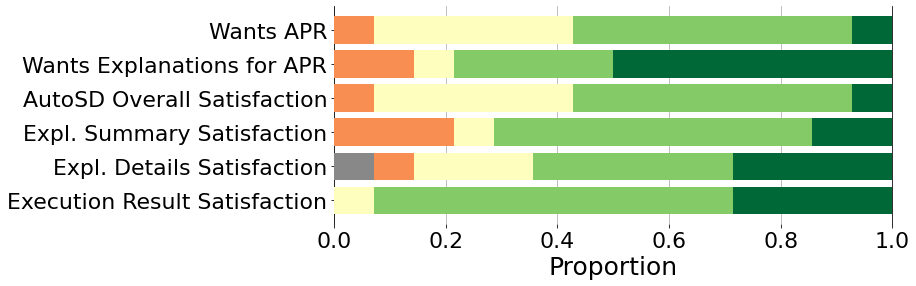

In [13]:
known_pqnre_answs = pqnre_df[(pqnre_df.answerer != 'unknown') & (pqnre_df.answerer.str.contains('student'))]

zero2five_likerts = []
for key in perf_qs:
    zero2five_likerts.append({
        'key': key,
        'resps': Counter(known_pqnre_answs[known_pqnre_answs[1]==key][2]),
    })

level_values = [[] for _ in range(6)]
for likert_obj in zero2five_likerts:
    key, counter_obj = likert_obj['key'], likert_obj['resps']
    total_resps = sum(counter_obj.values())
    for i in range(6):
        if i in counter_obj:
            level_values[i].append(counter_obj[i]/total_resps)
        else:
            level_values[i].append(0)

cNorm  = colors.Normalize(vmin=0, vmax=1)
color_map = cmx.ScalarMappable(norm=cNorm, cmap='RdYlGn')

pretty_names = OrderedDict({
    'apr_desirability': 'Wants APR',
    'expl_help_decision': 'Wants Explanations for APR',
    'expl_help_confidence': 'AutoSD Overall Satisfaction',
    'header_utility': 'Expl. Summary Satisfaction',
    'detail_utility': 'Expl. Details Satisfaction',
    'actual_exec': 'Execution Result Satisfaction'
})
level_labels = OrderedDict({
    0: '0 (unused)',
    1: '1 (no)',
    2: '2',
    3: '3',
    4: '4',
    5: '5 (yes)'
})
    
plt.rcParams['figure.figsize'] = [10, 4]
yrange = range(5, -1, -1)
curr_sums = [0 for _ in range(len(level_values[0]))]
for i in range(len(level_values)):
    curr_level_values = level_values[i]
    color_value = '#888' if i == 0 else color_map.to_rgba((i-1)/4)
    plt.barh(yrange, 
             curr_level_values, 
             tick_label=list(pretty_names.values()), 
             left=curr_sums, 
             color=color_value, 
             label=level_labels[i], 
             zorder=3)
    curr_sums = [x+y for x, y in zip(curr_sums, curr_level_values)]
plt.tick_params(labelsize=22)
plt.xlim(0, 1)
plt.xlabel('Proportion', fontsize=25)
plt.grid(zorder=0)
sns.despine(top=True, right=False, bottom=True)